# 결과
- [ 2024.01.23 ]  
- 하이퍼파라미터 튜닝을 옵튜나로 했을때, 테스트셋 손실함수는 오히려높게나왔다.
- 하지만 최신주가데이터에 대입할때 손실함수가 더 적게나왔다.

In [4]:
import yfinance
import numpy as np
import tensorflow as tf
import os

# Original dataset
df = yfinance.download('AAPL','2000-1-1','2020-1-1')
df = df.drop(['Volume'],1).drop(['Adj Close'],1)
display(df)

# 정규화 0~1
def normalize_data(dataset):
    cols = dataset.columns.tolist()
    # 편의상 모든컬럼명을 인덱스(실수)로 바꿈
    col_name = [0]*len(cols)          # [0, 0, 0, 0]
    for i in range(len(cols)):
        col_name[i] = i               # [0, 1, 2, 3]
    dataset.columns = col_name
    dtypes = dataset.dtypes.tolist()
    minmax = list()
    for column in dataset:
        dataset = dataset.astype({column: 'float32'})
    # 각 컬럼의 min, max 저장(정규화를 위함)
    for i in range(len(cols)):
        col_values = dataset[col_name[i]]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    # 0~1사이값으로 정규화
    for column in dataset:
        values = dataset[column].values
        for i in range(len(values)):
            values[i] = (values[i] - minmax[column][0]) / (minmax[column][1] - minmax[column][0])
        dataset[column] = values
    dataset[column] = values
    return dataset,minmax
    

dataset, minmax = normalize_data(df)
values = dataset.values
display("< df >", df.head(21), "< dataset >", dataset.head(21))
# 종가 예측은 11번째부터 시작 (1.18일부터)

def split_sequences(sequence, n_steps):
    X,y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1: 
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # 오프셋 정렬
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
    

def data_setup(n_steps, sequence):
    X, y = split_sequences(sequence, n_steps)
    print("< X > \n",X[:2],X.shape)                   # X : 10일분의 데이터묶음이 5021개
    print("< y > \n",y[:2],y.shape)                   # y : X의 각 묶음의 마지막날의 다음날데이터(예측할 타겟)
    n_features = X.shape[2]                       # X의 피쳐(특성) 수
    X = X.reshape((len(X), n_steps, n_features))  # 형태재구성 (샘플 수, 시퀀스 길이, 특성 수)
    # 
    new_y = []
    for term in y:
        new_term = term[-1]                       # 종가 컬럼만 추출
        new_y.append(new_term)
    return X, np.array(new_y), n_features

n_steps = 10        # 10일 분량
rel_test_len = 0.1  # 트 : 테 = 9 : 1
X,y,n_features = data_setup(n_steps, values)


X_test, y_test =  X[:int(len(X) * rel_test_len)], y[:int(len(X) * rel_test_len)]
X_train, y_train = X[int(len(X) * rel_test_len):], y[int(len(X) * rel_test_len):]

print(" < last y > \n",y[:10], y.shape)
print("< n_features >\n",n_features)

# array([0.9280131 , 0.95145106, 1.013393  , 0.99386203, 0.948661  ,
#        1.002232  , 0.98381704, 0.982143  , 0.907366  , 0.92633903],

[*********************100%%**********************]  1 of 1 completed
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_94023/2861494198.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_94023/2861494198.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)


,Open,High,Low,Close
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497
2019-12-26,71.205002,72.495003,71.175003,72.477501
2019-12-27,72.779999,73.492500,72.029999,72.449997


'< df >'

,0,1,2,3
Date,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442
2000-01-04,0.966518,0.987723,0.903460,0.915179
2000-01-05,0.926339,0.987165,0.919643,0.928571
2000-01-06,0.947545,0.955357,0.848214,0.848214
2000-01-07,0.861607,0.901786,0.852679,0.888393
2000-01-10,0.910714,0.912946,0.845982,0.872768
2000-01-11,0.856585,0.887277,0.808036,0.828125
2000-01-12,0.848214,0.852679,0.772321,0.778460
2000-01-13,0.843610,0.881696,0.825893,0.863839


'< dataset >'

,0,1,2,3
Date,,,,
2000-01-03,0.009710,0.010496,0.009435,0.010456
2000-01-04,0.010125,0.010268,0.009373,0.009305
2000-01-05,0.009571,0.010260,0.009598,0.009488
2000-01-06,0.009864,0.009826,0.008608,0.008389
2000-01-07,0.008679,0.009095,0.008670,0.008939
2000-01-10,0.009356,0.009247,0.008577,0.008725
2000-01-11,0.008610,0.008897,0.008051,0.008115
2000-01-12,0.008494,0.008424,0.007556,0.007436
2000-01-13,0.008431,0.008820,0.008298,0.008603


< X > 
 [[[0.0097097  0.01049631 0.00943526 0.01045606]
  [0.01012507 0.01026779 0.00937339 0.00930459]
  [0.00957124 0.01026017 0.00959768 0.00948759]
  [0.00986355 0.00982597 0.00860771 0.00838949]
  [0.00867898 0.0090947  0.0086696  0.00893855]
  [0.00935587 0.00924704 0.00857678 0.00872503]
  [0.00860976 0.00889664 0.00805087 0.00811497]
  [0.00849437 0.00842436 0.00755588 0.00743628]
  [0.00843091 0.00882046 0.00829836 0.00860301]
  [0.00910973 0.00924704 0.0091491  0.00905293]]

 [[0.01012507 0.01026779 0.00937339 0.00930459]
  [0.00957124 0.01026017 0.00959768 0.00948759]
  [0.00986355 0.00982597 0.00860771 0.00838949]
  [0.00867898 0.0090947  0.0086696  0.00893855]
  [0.00935587 0.00924704 0.00857678 0.00872503]
  [0.00860976 0.00889664 0.00805087 0.00811497]
  [0.00849437 0.00842436 0.00755588 0.00743628]
  [0.00843091 0.00882046 0.00829836 0.00860301]
  [0.00910973 0.00924704 0.0091491  0.00905293]
  [0.00923281 0.0097041  0.00928058 0.00947997]]] (5021, 10, 4)
< y > 
 [[0.00

In [11]:
import optuna
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout

# 저장할 경로 설정
model_dir = "/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/model_test" 
os.makedirs(model_dir, exist_ok=True)  # 경로가 없으면 생성

def create_model(trial):
    # 하이퍼파라미터 설정
    num_filters = trial.suggest_categorical('num_filters', [32, 64, 128])
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
    pool_size = trial.suggest_categorical('pool_size', [1, 2])
    dense_units = trial.suggest_categorical('dense_units', [50, 100, 150])

    # 모델 생성
    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(10, 4)))
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    return model

def objective(trial):
    # 모델 생성
    model = create_model(trial)

    # 조기 중단(Early Stopping) 설정
    early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=2)
    
    # 모델 훈련
    model.fit(X_train, y_train, 
              epochs=100, 
              validation_data=(X_test, y_test), 
              callbacks=[early_stopping], 
              verbose=2)
    
    # 모델 평가
    loss = model.evaluate(X_test, y_test, verbose=2)
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# 최적의 하이퍼파라미터로 모델 재생성 및 훈련
best_trial = study.best_trial
model = create_model(best_trial)
model.fit(X_train, y_train, 
          epochs=1000, 
          validation_data=(X_test, y_test), 
          verbose=2)

# 최적의 모델 구조를 JSON 형태로 저장
model_json = model.to_json()
with open(os.path.join(model_dir, "Tuned_CNN.json"), "w") as json_file:
    json_file.write(model_json)
ß
# 최적의 모델 가중치 저장
model.save_weights(os.path.join(model_dir, "Tuned_CNN_weights.h5"))


[I 2024-01-22 22:51:59,179] A new study created in memory with name: no-name-8d6d1444-62b7-4255-9627-38c6e50530ec


Epoch 1/100


2024-01-22 22:51:59.385002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 0.0153 - val_loss: 2.7369e-04 - 1s/epoch - 8ms/step
Epoch 2/100


2024-01-22 22:52:00.316439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 3.3790e-04 - val_loss: 1.3626e-04 - 566ms/epoch - 4ms/step
Epoch 3/100
142/142 - 1s - loss: 3.3320e-04 - val_loss: 7.9609e-05 - 554ms/epoch - 4ms/step
Epoch 4/100
142/142 - 1s - loss: 2.9806e-04 - val_loss: 4.2025e-05 - 547ms/epoch - 4ms/step
Epoch 5/100
142/142 - 1s - loss: 2.6411e-04 - val_loss: 2.7259e-05 - 557ms/epoch - 4ms/step
Epoch 6/100
142/142 - 1s - loss: 2.7514e-04 - val_loss: 1.9509e-05 - 554ms/epoch - 4ms/step
Epoch 7/100
142/142 - 1s - loss: 1.7936e-04 - val_loss: 1.4323e-05 - 564ms/epoch - 4ms/step
Epoch 8/100
142/142 - 1s - loss: 1.3262e-04 - val_loss: 1.0385e-05 - 570ms/epoch - 4ms/step
Epoch 9/100
142/142 - 1s - loss: 1.0512e-04 - val_loss: 9.5244e-06 - 568ms/epoch - 4ms/step
Epoch 10/100
142/142 - 1s - loss: 1.4441e-04 - val_loss: 8.6509e-06 - 563ms/epoch - 4ms/step
Epoch 11/100
142/142 - 1s - loss: 1.3042e-04 - val_loss: 7.6327e-06 - 563ms/epoch - 4ms/step
Epoch 12/100
142/142 - 1s - loss: 1.6601e-04 - val_loss: 8.2303e-06 - 554ms/epoch - 4ms/st

Epoch 91/100
142/142 - 1s - loss: 5.1601e-05 - val_loss: 8.1783e-07 - 557ms/epoch - 4ms/step
Epoch 92/100
142/142 - 1s - loss: 6.7999e-05 - val_loss: 7.5672e-07 - 549ms/epoch - 4ms/step
Epoch 93/100
142/142 - 1s - loss: 5.3701e-05 - val_loss: 8.7520e-07 - 545ms/epoch - 4ms/step
Epoch 94/100
142/142 - 1s - loss: 4.5532e-05 - val_loss: 8.0118e-07 - 546ms/epoch - 4ms/step
Epoch 95/100
142/142 - 1s - loss: 4.4188e-05 - val_loss: 7.8756e-07 - 546ms/epoch - 4ms/step
Epoch 96/100
142/142 - 1s - loss: 4.6715e-05 - val_loss: 1.0557e-06 - 548ms/epoch - 4ms/step
Epoch 97/100
142/142 - 1s - loss: 4.2301e-05 - val_loss: 7.9262e-07 - 555ms/epoch - 4ms/step
Epoch 98/100
142/142 - 1s - loss: 4.6455e-05 - val_loss: 7.6624e-07 - 551ms/epoch - 4ms/step
Epoch 99/100
142/142 - 1s - loss: 5.0955e-05 - val_loss: 1.4382e-06 - 559ms/epoch - 4ms/step
Epoch 100/100
142/142 - 1s - loss: 5.7080e-05 - val_loss: 8.9054e-07 - 562ms/epoch - 4ms/step
16/16 - 0s - loss: 8.9054e-07 - 38ms/epoch - 2ms/step


[I 2024-01-22 22:52:55,334] Trial 0 finished with value: 8.905436175155046e-07 and parameters: {'num_filters': 128, 'kernel_size': 5, 'pool_size': 1, 'dense_units': 150}. Best is trial 0 with value: 8.905436175155046e-07.


Epoch 1/100


2024-01-22 22:52:55.508674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 0.0224 - val_loss: 7.7612e-04 - 1s/epoch - 8ms/step
Epoch 2/100


2024-01-22 22:52:56.467277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 3.9919e-04 - val_loss: 4.2046e-04 - 556ms/epoch - 4ms/step
Epoch 3/100
142/142 - 1s - loss: 3.0671e-04 - val_loss: 2.8259e-04 - 519ms/epoch - 4ms/step
Epoch 4/100
142/142 - 1s - loss: 2.5357e-04 - val_loss: 2.0619e-04 - 519ms/epoch - 4ms/step
Epoch 5/100
142/142 - 1s - loss: 2.1014e-04 - val_loss: 1.6269e-04 - 513ms/epoch - 4ms/step
Epoch 6/100
142/142 - 1s - loss: 2.3976e-04 - val_loss: 1.3061e-04 - 519ms/epoch - 4ms/step
Epoch 7/100
142/142 - 1s - loss: 2.9082e-04 - val_loss: 1.0567e-04 - 515ms/epoch - 4ms/step
Epoch 8/100
142/142 - 1s - loss: 1.7394e-04 - val_loss: 9.5138e-05 - 517ms/epoch - 4ms/step
Epoch 9/100
142/142 - 1s - loss: 1.6683e-04 - val_loss: 8.9160e-05 - 515ms/epoch - 4ms/step
Epoch 10/100
142/142 - 1s - loss: 1.8266e-04 - val_loss: 7.0818e-05 - 514ms/epoch - 4ms/step
Epoch 11/100
142/142 - 1s - loss: 2.4956e-04 - val_loss: 6.9820e-05 - 519ms/epoch - 4ms/step
Epoch 12/100
142/142 - 1s - loss: 1.9106e-04 - val_loss: 5.1967e-05 - 514ms/epoch - 4ms/st

Epoch 91/100
142/142 - 1s - loss: 4.8863e-05 - val_loss: 2.4255e-06 - 516ms/epoch - 4ms/step
Epoch 92/100
142/142 - 1s - loss: 5.1096e-05 - val_loss: 1.9250e-06 - 521ms/epoch - 4ms/step
Epoch 93/100
142/142 - 1s - loss: 5.8474e-05 - val_loss: 1.4811e-06 - 517ms/epoch - 4ms/step
Epoch 94/100
142/142 - 1s - loss: 5.9082e-05 - val_loss: 1.9764e-06 - 515ms/epoch - 4ms/step
Epoch 95/100
142/142 - 1s - loss: 4.9355e-05 - val_loss: 1.5108e-06 - 517ms/epoch - 4ms/step
Epoch 96/100
142/142 - 1s - loss: 4.5420e-05 - val_loss: 1.3631e-06 - 514ms/epoch - 4ms/step
Epoch 97/100
142/142 - 1s - loss: 4.9073e-05 - val_loss: 1.4598e-06 - 513ms/epoch - 4ms/step
Epoch 98/100
142/142 - 1s - loss: 4.2979e-05 - val_loss: 2.4341e-06 - 563ms/epoch - 4ms/step
Epoch 99/100
142/142 - 1s - loss: 5.2082e-05 - val_loss: 1.2282e-06 - 521ms/epoch - 4ms/step
Epoch 100/100
142/142 - 1s - loss: 4.5408e-05 - val_loss: 1.9370e-06 - 516ms/epoch - 4ms/step
16/16 - 0s - loss: 1.9370e-06 - 37ms/epoch - 2ms/step


[I 2024-01-22 22:53:48,326] Trial 1 finished with value: 1.9370233985682717e-06 and parameters: {'num_filters': 32, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 150}. Best is trial 0 with value: 8.905436175155046e-07.


Epoch 1/100


2024-01-22 22:53:48.495701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 0.0280 - val_loss: 0.0019 - 1s/epoch - 7ms/step
Epoch 2/100


2024-01-22 22:53:49.269127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 4.9139e-04 - val_loss: 6.6696e-04 - 529ms/epoch - 4ms/step
Epoch 3/100
142/142 - 1s - loss: 3.2166e-04 - val_loss: 4.0617e-04 - 526ms/epoch - 4ms/step
Epoch 4/100
142/142 - 1s - loss: 3.7623e-04 - val_loss: 3.1883e-04 - 529ms/epoch - 4ms/step
Epoch 5/100
142/142 - 1s - loss: 2.9210e-04 - val_loss: 2.9285e-04 - 519ms/epoch - 4ms/step
Epoch 6/100
142/142 - 1s - loss: 2.4054e-04 - val_loss: 2.2129e-04 - 523ms/epoch - 4ms/step
Epoch 7/100
142/142 - 1s - loss: 2.8240e-04 - val_loss: 1.6569e-04 - 518ms/epoch - 4ms/step
Epoch 8/100
142/142 - 1s - loss: 2.1457e-04 - val_loss: 1.4152e-04 - 517ms/epoch - 4ms/step
Epoch 9/100
142/142 - 1s - loss: 2.3153e-04 - val_loss: 1.3114e-04 - 515ms/epoch - 4ms/step
Epoch 10/100
142/142 - 1s - loss: 2.0371e-04 - val_loss: 9.5953e-05 - 522ms/epoch - 4ms/step
Epoch 11/100
142/142 - 1s - loss: 1.8847e-04 - val_loss: 9.9366e-05 - 518ms/epoch - 4ms/step
Epoch 12/100
142/142 - 1s - loss: 1.8204e-04 - val_loss: 6.5401e-05 - 515ms/epoch - 4ms/st

Epoch 91/100
142/142 - 1s - loss: 7.3672e-05 - val_loss: 2.7069e-06 - 543ms/epoch - 4ms/step
Epoch 92/100
142/142 - 1s - loss: 9.9506e-05 - val_loss: 5.5330e-06 - 514ms/epoch - 4ms/step
Epoch 93/100
142/142 - 1s - loss: 9.0227e-05 - val_loss: 3.5750e-06 - 513ms/epoch - 4ms/step
Epoch 94/100
142/142 - 1s - loss: 6.7384e-05 - val_loss: 2.1176e-06 - 513ms/epoch - 4ms/step
Epoch 95/100
142/142 - 1s - loss: 6.1770e-05 - val_loss: 2.0578e-06 - 517ms/epoch - 4ms/step
Epoch 96/100
142/142 - 1s - loss: 6.5687e-05 - val_loss: 2.5907e-06 - 519ms/epoch - 4ms/step
Epoch 97/100
142/142 - 1s - loss: 7.2810e-05 - val_loss: 4.9499e-06 - 518ms/epoch - 4ms/step
Epoch 98/100
142/142 - 1s - loss: 8.5381e-05 - val_loss: 3.1705e-06 - 516ms/epoch - 4ms/step
Epoch 99/100
142/142 - 1s - loss: 6.3467e-05 - val_loss: 2.3512e-06 - 517ms/epoch - 4ms/step
Epoch 100/100
142/142 - 1s - loss: 6.8888e-05 - val_loss: 3.1290e-06 - 520ms/epoch - 4ms/step
16/16 - 0s - loss: 3.1290e-06 - 37ms/epoch - 2ms/step


[I 2024-01-22 22:54:41,803] Trial 2 finished with value: 3.1290226161218015e-06 and parameters: {'num_filters': 32, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 50}. Best is trial 0 with value: 8.905436175155046e-07.


Epoch 1/100


2024-01-22 22:54:41.975034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 0.0145 - val_loss: 6.6752e-05 - 1s/epoch - 8ms/step
Epoch 2/100


2024-01-22 22:54:42.807941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 3.0640e-04 - val_loss: 2.1016e-05 - 538ms/epoch - 4ms/step
Epoch 3/100
142/142 - 1s - loss: 2.7117e-04 - val_loss: 1.5536e-05 - 538ms/epoch - 4ms/step
Epoch 4/100
142/142 - 1s - loss: 1.9712e-04 - val_loss: 8.4821e-06 - 567ms/epoch - 4ms/step
Epoch 5/100
142/142 - 1s - loss: 2.4057e-04 - val_loss: 7.0566e-06 - 560ms/epoch - 4ms/step
Epoch 6/100
142/142 - 1s - loss: 1.6494e-04 - val_loss: 7.4916e-06 - 533ms/epoch - 4ms/step
Epoch 7/100
142/142 - 1s - loss: 1.6939e-04 - val_loss: 5.6094e-06 - 529ms/epoch - 4ms/step
Epoch 8/100
142/142 - 1s - loss: 1.2612e-04 - val_loss: 5.2489e-06 - 541ms/epoch - 4ms/step
Epoch 9/100
142/142 - 1s - loss: 1.5403e-04 - val_loss: 4.4169e-06 - 573ms/epoch - 4ms/step
Epoch 10/100
142/142 - 1s - loss: 1.1148e-04 - val_loss: 4.1933e-06 - 552ms/epoch - 4ms/step
Epoch 11/100
142/142 - 1s - loss: 1.9252e-04 - val_loss: 4.8288e-06 - 537ms/epoch - 4ms/step
Epoch 12/100
142/142 - 1s - loss: 1.4723e-04 - val_loss: 3.4408e-06 - 535ms/epoch - 4ms/st

Epoch 91/100
142/142 - 1s - loss: 4.8045e-05 - val_loss: 1.0666e-06 - 534ms/epoch - 4ms/step
Epoch 92/100
142/142 - 1s - loss: 5.3281e-05 - val_loss: 2.3017e-06 - 544ms/epoch - 4ms/step
Epoch 93/100
142/142 - 1s - loss: 4.9494e-05 - val_loss: 1.0997e-06 - 542ms/epoch - 4ms/step
Epoch 94/100
142/142 - 1s - loss: 4.8911e-05 - val_loss: 1.0525e-06 - 529ms/epoch - 4ms/step
Epoch 95/100
142/142 - 1s - loss: 4.7362e-05 - val_loss: 1.0505e-06 - 530ms/epoch - 4ms/step
Epoch 96/100
142/142 - 1s - loss: 4.6284e-05 - val_loss: 1.6730e-06 - 529ms/epoch - 4ms/step
Epoch 97/100
142/142 - 1s - loss: 5.0963e-05 - val_loss: 1.0373e-06 - 536ms/epoch - 4ms/step
Epoch 98/100
142/142 - 1s - loss: 5.0506e-05 - val_loss: 2.3579e-06 - 533ms/epoch - 4ms/step
Epoch 99/100
142/142 - 1s - loss: 4.4996e-05 - val_loss: 1.1007e-06 - 530ms/epoch - 4ms/step
Epoch 100/100
142/142 - 1s - loss: 4.6273e-05 - val_loss: 2.6365e-06 - 535ms/epoch - 4ms/step
16/16 - 0s - loss: 2.6365e-06 - 41ms/epoch - 3ms/step


[I 2024-01-22 22:55:36,324] Trial 3 finished with value: 2.6364659788669087e-06 and parameters: {'num_filters': 128, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 150}. Best is trial 0 with value: 8.905436175155046e-07.


Epoch 1/100


2024-01-22 22:55:36.495039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 0.0190 - val_loss: 6.8334e-05 - 1s/epoch - 7ms/step
Epoch 2/100


2024-01-22 22:55:37.295799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 2.8352e-04 - val_loss: 2.6491e-05 - 543ms/epoch - 4ms/step
Epoch 3/100
142/142 - 1s - loss: 3.0165e-04 - val_loss: 2.0210e-05 - 552ms/epoch - 4ms/step
Epoch 4/100
142/142 - 1s - loss: 1.9940e-04 - val_loss: 1.0308e-05 - 554ms/epoch - 4ms/step
Epoch 5/100
142/142 - 1s - loss: 1.8061e-04 - val_loss: 8.1513e-06 - 554ms/epoch - 4ms/step
Epoch 6/100
142/142 - 1s - loss: 1.7853e-04 - val_loss: 7.2236e-06 - 537ms/epoch - 4ms/step
Epoch 7/100
142/142 - 1s - loss: 1.9258e-04 - val_loss: 6.1197e-06 - 572ms/epoch - 4ms/step
Epoch 8/100
142/142 - 1s - loss: 1.6696e-04 - val_loss: 5.1925e-06 - 609ms/epoch - 4ms/step
Epoch 9/100
142/142 - 1s - loss: 1.9304e-04 - val_loss: 4.7240e-06 - 583ms/epoch - 4ms/step
Epoch 10/100
142/142 - 1s - loss: 1.7022e-04 - val_loss: 3.9901e-06 - 530ms/epoch - 4ms/step
Epoch 11/100
142/142 - 1s - loss: 1.7003e-04 - val_loss: 5.1908e-06 - 530ms/epoch - 4ms/step
Epoch 12/100
142/142 - 1s - loss: 1.4124e-04 - val_loss: 3.1286e-06 - 539ms/epoch - 4ms/st

Epoch 91/100
142/142 - 1s - loss: 4.8350e-05 - val_loss: 9.9394e-07 - 554ms/epoch - 4ms/step
Epoch 92/100
142/142 - 1s - loss: 4.9277e-05 - val_loss: 1.8770e-06 - 527ms/epoch - 4ms/step
Epoch 93/100
142/142 - 1s - loss: 5.7916e-05 - val_loss: 3.3828e-06 - 522ms/epoch - 4ms/step
Epoch 94/100
142/142 - 1s - loss: 5.4772e-05 - val_loss: 1.5935e-06 - 523ms/epoch - 4ms/step
Epoch 95/100
142/142 - 1s - loss: 4.5976e-05 - val_loss: 1.2237e-06 - 521ms/epoch - 4ms/step
Epoch 96/100
142/142 - 1s - loss: 4.0357e-05 - val_loss: 7.2177e-07 - 524ms/epoch - 4ms/step
Epoch 97/100
142/142 - 1s - loss: 4.2182e-05 - val_loss: 8.8800e-07 - 526ms/epoch - 4ms/step
Epoch 98/100
142/142 - 1s - loss: 4.8002e-05 - val_loss: 7.8104e-07 - 523ms/epoch - 4ms/step
Epoch 99/100
142/142 - 1s - loss: 4.8948e-05 - val_loss: 8.4478e-07 - 525ms/epoch - 4ms/step
Epoch 100/100
142/142 - 1s - loss: 4.9769e-05 - val_loss: 1.0843e-06 - 522ms/epoch - 4ms/step
16/16 - 0s - loss: 1.0843e-06 - 37ms/epoch - 2ms/step


[I 2024-01-22 22:56:32,226] Trial 4 finished with value: 1.084284122043755e-06 and parameters: {'num_filters': 64, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 150}. Best is trial 0 with value: 8.905436175155046e-07.


Epoch 1/100


2024-01-22 22:56:32.402297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 0.0195 - val_loss: 3.5409e-04 - 1s/epoch - 8ms/step
Epoch 2/100


2024-01-22 22:56:33.221959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 3.7456e-04 - val_loss: 1.9203e-04 - 570ms/epoch - 4ms/step
Epoch 3/100
142/142 - 1s - loss: 3.7160e-04 - val_loss: 1.2310e-04 - 563ms/epoch - 4ms/step
Epoch 4/100
142/142 - 1s - loss: 3.0035e-04 - val_loss: 1.0988e-04 - 553ms/epoch - 4ms/step
Epoch 5/100
142/142 - 1s - loss: 2.1534e-04 - val_loss: 7.4172e-05 - 573ms/epoch - 4ms/step
Epoch 6/100
142/142 - 1s - loss: 1.8396e-04 - val_loss: 6.4727e-05 - 573ms/epoch - 4ms/step
Epoch 7/100
142/142 - 1s - loss: 2.1242e-04 - val_loss: 4.1565e-05 - 555ms/epoch - 4ms/step
Epoch 8/100
142/142 - 1s - loss: 1.7761e-04 - val_loss: 3.9884e-05 - 592ms/epoch - 4ms/step
Epoch 9/100
142/142 - 1s - loss: 1.8161e-04 - val_loss: 3.1071e-05 - 555ms/epoch - 4ms/step
Epoch 10/100
142/142 - 1s - loss: 1.6506e-04 - val_loss: 2.2083e-05 - 586ms/epoch - 4ms/step
Epoch 11/100
142/142 - 1s - loss: 2.2798e-04 - val_loss: 2.9356e-05 - 554ms/epoch - 4ms/step
Epoch 12/100
142/142 - 1s - loss: 1.4463e-04 - val_loss: 2.3915e-05 - 548ms/epoch - 4ms/st

Epoch 91/100
142/142 - 1s - loss: 4.2704e-05 - val_loss: 8.6043e-07 - 540ms/epoch - 4ms/step
Epoch 92/100
142/142 - 1s - loss: 4.3623e-05 - val_loss: 9.2094e-07 - 557ms/epoch - 4ms/step
Epoch 93/100
142/142 - 1s - loss: 4.3639e-05 - val_loss: 8.7143e-07 - 562ms/epoch - 4ms/step
Epoch 94/100
142/142 - 1s - loss: 6.0269e-05 - val_loss: 8.2186e-07 - 542ms/epoch - 4ms/step
Epoch 95/100
142/142 - 1s - loss: 6.2390e-05 - val_loss: 1.2421e-06 - 539ms/epoch - 4ms/step
Epoch 96/100
142/142 - 1s - loss: 5.5259e-05 - val_loss: 9.4450e-07 - 546ms/epoch - 4ms/step
Epoch 97/100
142/142 - 1s - loss: 5.0393e-05 - val_loss: 2.1529e-06 - 543ms/epoch - 4ms/step
Epoch 98/100
142/142 - 1s - loss: 4.7725e-05 - val_loss: 8.4983e-07 - 540ms/epoch - 4ms/step
Epoch 99/100
142/142 - 1s - loss: 6.0668e-05 - val_loss: 1.5571e-06 - 540ms/epoch - 4ms/step
Epoch 100/100
142/142 - 1s - loss: 5.8924e-05 - val_loss: 3.3999e-06 - 561ms/epoch - 4ms/step
16/16 - 0s - loss: 3.3999e-06 - 38ms/epoch - 2ms/step


[I 2024-01-22 22:57:28,129] Trial 5 finished with value: 3.399859679120709e-06 and parameters: {'num_filters': 128, 'kernel_size': 5, 'pool_size': 1, 'dense_units': 50}. Best is trial 0 with value: 8.905436175155046e-07.


Epoch 1/100


2024-01-22 22:57:28.290780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 0.0172 - val_loss: 3.1313e-04 - 1s/epoch - 8ms/step
Epoch 2/100


2024-01-22 22:57:29.120276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 3.2348e-04 - val_loss: 1.7569e-04 - 548ms/epoch - 4ms/step
Epoch 3/100
142/142 - 1s - loss: 3.1480e-04 - val_loss: 1.2129e-04 - 556ms/epoch - 4ms/step
Epoch 4/100
142/142 - 1s - loss: 2.4148e-04 - val_loss: 9.1716e-05 - 557ms/epoch - 4ms/step
Epoch 5/100
142/142 - 1s - loss: 2.4730e-04 - val_loss: 7.9023e-05 - 553ms/epoch - 4ms/step
Epoch 6/100
142/142 - 1s - loss: 1.9552e-04 - val_loss: 6.2205e-05 - 569ms/epoch - 4ms/step
Epoch 7/100
142/142 - 1s - loss: 2.1231e-04 - val_loss: 4.7514e-05 - 563ms/epoch - 4ms/step
Epoch 8/100
142/142 - 1s - loss: 1.7985e-04 - val_loss: 3.3903e-05 - 552ms/epoch - 4ms/step
Epoch 9/100
142/142 - 1s - loss: 1.9904e-04 - val_loss: 2.4498e-05 - 547ms/epoch - 4ms/step
Epoch 10/100
142/142 - 1s - loss: 1.9124e-04 - val_loss: 2.0895e-05 - 548ms/epoch - 4ms/step
Epoch 11/100
142/142 - 1s - loss: 1.1456e-04 - val_loss: 1.7982e-05 - 559ms/epoch - 4ms/step
Epoch 12/100
142/142 - 1s - loss: 1.4790e-04 - val_loss: 1.4237e-05 - 557ms/epoch - 4ms/st

Epoch 91/100
142/142 - 1s - loss: 4.5951e-05 - val_loss: 1.1590e-06 - 555ms/epoch - 4ms/step
Epoch 92/100
142/142 - 1s - loss: 5.4667e-05 - val_loss: 1.3012e-06 - 549ms/epoch - 4ms/step
Epoch 93/100
142/142 - 1s - loss: 6.6153e-05 - val_loss: 1.2474e-06 - 541ms/epoch - 4ms/step
Epoch 94/100
142/142 - 1s - loss: 5.4034e-05 - val_loss: 1.1057e-06 - 538ms/epoch - 4ms/step
Epoch 95/100
142/142 - 1s - loss: 6.5959e-05 - val_loss: 2.3733e-06 - 552ms/epoch - 4ms/step
Epoch 96/100
142/142 - 1s - loss: 4.6801e-05 - val_loss: 8.1060e-07 - 545ms/epoch - 4ms/step
Epoch 97/100
142/142 - 1s - loss: 4.5038e-05 - val_loss: 1.2084e-06 - 546ms/epoch - 4ms/step
Epoch 98/100
142/142 - 1s - loss: 4.6050e-05 - val_loss: 9.1798e-07 - 551ms/epoch - 4ms/step
Epoch 99/100
142/142 - 1s - loss: 4.4924e-05 - val_loss: 1.5783e-06 - 541ms/epoch - 4ms/step
Epoch 100/100
142/142 - 1s - loss: 4.7689e-05 - val_loss: 9.4719e-07 - 545ms/epoch - 4ms/step
16/16 - 0s - loss: 9.4719e-07 - 39ms/epoch - 2ms/step


[I 2024-01-22 22:58:23,842] Trial 6 finished with value: 9.471932571614161e-07 and parameters: {'num_filters': 128, 'kernel_size': 5, 'pool_size': 1, 'dense_units': 100}. Best is trial 0 with value: 8.905436175155046e-07.


Epoch 1/100


2024-01-22 22:58:24.002613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 0.0215 - val_loss: 3.3160e-04 - 1s/epoch - 7ms/step
Epoch 2/100


2024-01-22 22:58:24.785882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 3.4549e-04 - val_loss: 1.4140e-04 - 549ms/epoch - 4ms/step
Epoch 3/100
142/142 - 1s - loss: 2.5968e-04 - val_loss: 6.3461e-05 - 557ms/epoch - 4ms/step
Epoch 4/100
142/142 - 1s - loss: 2.2806e-04 - val_loss: 3.3353e-05 - 541ms/epoch - 4ms/step
Epoch 5/100
142/142 - 1s - loss: 1.6387e-04 - val_loss: 2.9779e-05 - 541ms/epoch - 4ms/step
Epoch 6/100
142/142 - 1s - loss: 1.9541e-04 - val_loss: 2.3473e-05 - 537ms/epoch - 4ms/step
Epoch 7/100
142/142 - 1s - loss: 1.6804e-04 - val_loss: 1.8664e-05 - 535ms/epoch - 4ms/step
Epoch 8/100
142/142 - 1s - loss: 1.4551e-04 - val_loss: 1.8567e-05 - 537ms/epoch - 4ms/step
Epoch 9/100
142/142 - 1s - loss: 1.9975e-04 - val_loss: 1.4328e-05 - 542ms/epoch - 4ms/step
Epoch 10/100
142/142 - 1s - loss: 1.7996e-04 - val_loss: 1.2758e-05 - 533ms/epoch - 4ms/step
Epoch 11/100
142/142 - 1s - loss: 1.1721e-04 - val_loss: 8.7706e-06 - 537ms/epoch - 4ms/step
Epoch 12/100
142/142 - 1s - loss: 1.1134e-04 - val_loss: 9.9116e-06 - 534ms/epoch - 4ms/st

Epoch 91/100
142/142 - 1s - loss: 5.7609e-05 - val_loss: 1.0157e-06 - 530ms/epoch - 4ms/step
Epoch 92/100
142/142 - 1s - loss: 5.7797e-05 - val_loss: 2.0126e-06 - 528ms/epoch - 4ms/step
Epoch 93/100
142/142 - 1s - loss: 6.3609e-05 - val_loss: 1.5476e-06 - 530ms/epoch - 4ms/step
Epoch 94/100
142/142 - 1s - loss: 4.5830e-05 - val_loss: 2.0490e-06 - 532ms/epoch - 4ms/step
Epoch 95/100
142/142 - 1s - loss: 5.0069e-05 - val_loss: 1.2138e-06 - 530ms/epoch - 4ms/step
Epoch 96/100
142/142 - 1s - loss: 5.1381e-05 - val_loss: 1.4660e-06 - 529ms/epoch - 4ms/step
Epoch 97/100
142/142 - 1s - loss: 5.7963e-05 - val_loss: 1.5378e-06 - 528ms/epoch - 4ms/step
Epoch 98/100
142/142 - 1s - loss: 7.3541e-05 - val_loss: 2.6809e-06 - 531ms/epoch - 4ms/step
Epoch 99/100
142/142 - 1s - loss: 4.2724e-05 - val_loss: 9.0467e-07 - 532ms/epoch - 4ms/step
Epoch 100/100
142/142 - 1s - loss: 5.3403e-05 - val_loss: 1.0294e-06 - 533ms/epoch - 4ms/step
16/16 - 0s - loss: 1.0294e-06 - 37ms/epoch - 2ms/step


[I 2024-01-22 22:59:18,019] Trial 7 finished with value: 1.0294210142092197e-06 and parameters: {'num_filters': 128, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 50}. Best is trial 0 with value: 8.905436175155046e-07.


Epoch 1/100


2024-01-22 22:59:18.191827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 0.0329 - val_loss: 0.0019 - 1s/epoch - 8ms/step
Epoch 2/100


2024-01-22 22:59:19.035851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 3.9676e-04 - val_loss: 5.8473e-04 - 542ms/epoch - 4ms/step
Epoch 3/100
142/142 - 1s - loss: 2.7849e-04 - val_loss: 3.3373e-04 - 541ms/epoch - 4ms/step
Epoch 4/100
142/142 - 1s - loss: 2.4983e-04 - val_loss: 2.4566e-04 - 543ms/epoch - 4ms/step
Epoch 5/100
142/142 - 1s - loss: 2.6049e-04 - val_loss: 2.0514e-04 - 544ms/epoch - 4ms/step
Epoch 6/100
142/142 - 1s - loss: 2.6107e-04 - val_loss: 1.5681e-04 - 547ms/epoch - 4ms/step
Epoch 7/100
142/142 - 1s - loss: 2.1004e-04 - val_loss: 1.2869e-04 - 538ms/epoch - 4ms/step
Epoch 8/100
142/142 - 1s - loss: 2.2521e-04 - val_loss: 1.0636e-04 - 532ms/epoch - 4ms/step
Epoch 9/100
142/142 - 1s - loss: 1.5976e-04 - val_loss: 1.0332e-04 - 525ms/epoch - 4ms/step
Epoch 10/100
142/142 - 1s - loss: 1.7425e-04 - val_loss: 9.1100e-05 - 533ms/epoch - 4ms/step
Epoch 11/100
142/142 - 1s - loss: 1.4243e-04 - val_loss: 8.2239e-05 - 552ms/epoch - 4ms/step
Epoch 12/100
142/142 - 1s - loss: 1.3756e-04 - val_loss: 6.3521e-05 - 524ms/epoch - 4ms/st

Epoch 91/100
142/142 - 1s - loss: 6.5529e-05 - val_loss: 2.2764e-06 - 531ms/epoch - 4ms/step
Epoch 92/100
142/142 - 1s - loss: 6.1169e-05 - val_loss: 2.2489e-06 - 519ms/epoch - 4ms/step
Epoch 93/100
142/142 - 1s - loss: 5.8550e-05 - val_loss: 1.8827e-06 - 532ms/epoch - 4ms/step
Epoch 94/100
142/142 - 1s - loss: 6.3719e-05 - val_loss: 3.1410e-06 - 516ms/epoch - 4ms/step
Epoch 95/100
142/142 - 1s - loss: 5.7266e-05 - val_loss: 2.1034e-06 - 520ms/epoch - 4ms/step
Epoch 96/100
142/142 - 1s - loss: 8.2317e-05 - val_loss: 3.0620e-06 - 523ms/epoch - 4ms/step
Epoch 97/100
142/142 - 1s - loss: 5.6437e-05 - val_loss: 1.8750e-06 - 522ms/epoch - 4ms/step
Epoch 98/100
142/142 - 1s - loss: 6.3687e-05 - val_loss: 2.2764e-06 - 516ms/epoch - 4ms/step
Epoch 99/100
142/142 - 1s - loss: 9.3366e-05 - val_loss: 2.3975e-06 - 517ms/epoch - 4ms/step
Epoch 100/100
142/142 - 1s - loss: 6.2399e-05 - val_loss: 2.3885e-06 - 515ms/epoch - 4ms/step
16/16 - 0s - loss: 2.3885e-06 - 37ms/epoch - 2ms/step


[I 2024-01-22 23:00:11,415] Trial 8 finished with value: 2.3884874735813355e-06 and parameters: {'num_filters': 32, 'kernel_size': 5, 'pool_size': 2, 'dense_units': 100}. Best is trial 0 with value: 8.905436175155046e-07.


Epoch 1/100


2024-01-22 23:00:11.576447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 0.0166 - val_loss: 2.2618e-04 - 1s/epoch - 7ms/step
Epoch 2/100


2024-01-22 23:00:12.374964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 2.5146e-04 - val_loss: 5.5879e-05 - 563ms/epoch - 4ms/step
Epoch 3/100
142/142 - 1s - loss: 1.9588e-04 - val_loss: 2.6635e-05 - 567ms/epoch - 4ms/step
Epoch 4/100
142/142 - 1s - loss: 2.5968e-04 - val_loss: 1.9151e-05 - 547ms/epoch - 4ms/step
Epoch 5/100
142/142 - 1s - loss: 2.1557e-04 - val_loss: 1.5406e-05 - 549ms/epoch - 4ms/step
Epoch 6/100
142/142 - 1s - loss: 1.9821e-04 - val_loss: 1.0813e-05 - 537ms/epoch - 4ms/step
Epoch 7/100
142/142 - 1s - loss: 1.8786e-04 - val_loss: 1.2560e-05 - 544ms/epoch - 4ms/step
Epoch 8/100
142/142 - 1s - loss: 1.3952e-04 - val_loss: 1.0546e-05 - 529ms/epoch - 4ms/step
Epoch 9/100
142/142 - 1s - loss: 1.3496e-04 - val_loss: 9.8548e-06 - 539ms/epoch - 4ms/step
Epoch 10/100
142/142 - 1s - loss: 1.2072e-04 - val_loss: 7.2180e-06 - 534ms/epoch - 4ms/step
Epoch 11/100
142/142 - 1s - loss: 1.5569e-04 - val_loss: 7.8438e-06 - 529ms/epoch - 4ms/step
Epoch 12/100
142/142 - 1s - loss: 1.6457e-04 - val_loss: 7.4368e-06 - 532ms/epoch - 4ms/st

Epoch 91/100
142/142 - 1s - loss: 4.3914e-05 - val_loss: 1.6624e-06 - 529ms/epoch - 4ms/step
Epoch 91: early stopping
16/16 - 0s - loss: 1.6624e-06 - 39ms/epoch - 2ms/step


[I 2024-01-22 23:01:00,915] Trial 9 finished with value: 1.6624231875539408e-06 and parameters: {'num_filters': 128, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 150}. Best is trial 0 with value: 8.905436175155046e-07.


Epoch 1/1000


2024-01-22 23:01:01.529411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 0.0154 - val_loss: 2.4191e-05 - 1s/epoch - 8ms/step
Epoch 2/1000


2024-01-22 23:01:02.364960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


142/142 - 1s - loss: 4.4343e-04 - val_loss: 9.5378e-06 - 564ms/epoch - 4ms/step
Epoch 3/1000
142/142 - 1s - loss: 2.2077e-04 - val_loss: 5.9570e-06 - 553ms/epoch - 4ms/step
Epoch 4/1000
142/142 - 1s - loss: 2.4389e-04 - val_loss: 4.7667e-06 - 588ms/epoch - 4ms/step
Epoch 5/1000
142/142 - 1s - loss: 1.5952e-04 - val_loss: 4.0108e-06 - 563ms/epoch - 4ms/step
Epoch 6/1000
142/142 - 1s - loss: 1.9351e-04 - val_loss: 3.6379e-06 - 586ms/epoch - 4ms/step
Epoch 7/1000
142/142 - 1s - loss: 1.5603e-04 - val_loss: 2.9356e-06 - 573ms/epoch - 4ms/step
Epoch 8/1000
142/142 - 1s - loss: 1.2891e-04 - val_loss: 2.4235e-06 - 555ms/epoch - 4ms/step
Epoch 9/1000
142/142 - 1s - loss: 1.5376e-04 - val_loss: 2.2070e-06 - 548ms/epoch - 4ms/step
Epoch 10/1000
142/142 - 1s - loss: 1.2553e-04 - val_loss: 2.4131e-06 - 561ms/epoch - 4ms/step
Epoch 11/1000
142/142 - 1s - loss: 3.1382e-04 - val_loss: 3.2390e-06 - 555ms/epoch - 4ms/step
Epoch 12/1000
142/142 - 1s - loss: 1.8400e-04 - val_loss: 6.1588e-06 - 553ms/epoc

Epoch 90/1000
142/142 - 1s - loss: 8.1247e-05 - val_loss: 1.0267e-06 - 546ms/epoch - 4ms/step
Epoch 91/1000
142/142 - 1s - loss: 4.4419e-05 - val_loss: 8.4177e-07 - 550ms/epoch - 4ms/step
Epoch 92/1000
142/142 - 1s - loss: 5.1808e-05 - val_loss: 1.2362e-06 - 543ms/epoch - 4ms/step
Epoch 93/1000
142/142 - 1s - loss: 5.9607e-05 - val_loss: 1.3661e-06 - 545ms/epoch - 4ms/step
Epoch 94/1000
142/142 - 1s - loss: 5.0272e-05 - val_loss: 1.4962e-06 - 563ms/epoch - 4ms/step
Epoch 95/1000
142/142 - 1s - loss: 4.8999e-05 - val_loss: 7.6808e-07 - 552ms/epoch - 4ms/step
Epoch 96/1000
142/142 - 1s - loss: 4.8005e-05 - val_loss: 2.6407e-06 - 543ms/epoch - 4ms/step
Epoch 97/1000
142/142 - 1s - loss: 5.8782e-05 - val_loss: 2.6761e-06 - 545ms/epoch - 4ms/step
Epoch 98/1000
142/142 - 1s - loss: 4.8587e-05 - val_loss: 1.0758e-06 - 546ms/epoch - 4ms/step
Epoch 99/1000
142/142 - 1s - loss: 4.5691e-05 - val_loss: 2.2912e-06 - 547ms/epoch - 4ms/step
Epoch 100/1000
142/142 - 1s - loss: 4.3130e-05 - val_loss: 1

Epoch 177/1000
142/142 - 1s - loss: 4.2418e-05 - val_loss: 7.0797e-07 - 554ms/epoch - 4ms/step
Epoch 178/1000
142/142 - 1s - loss: 4.7976e-05 - val_loss: 1.1550e-06 - 546ms/epoch - 4ms/step
Epoch 179/1000
142/142 - 1s - loss: 3.8028e-05 - val_loss: 8.8215e-07 - 554ms/epoch - 4ms/step
Epoch 180/1000
142/142 - 1s - loss: 4.0856e-05 - val_loss: 6.8237e-07 - 556ms/epoch - 4ms/step
Epoch 181/1000
142/142 - 1s - loss: 5.4764e-05 - val_loss: 1.2470e-06 - 545ms/epoch - 4ms/step
Epoch 182/1000
142/142 - 1s - loss: 3.4767e-05 - val_loss: 8.1192e-07 - 548ms/epoch - 4ms/step
Epoch 183/1000
142/142 - 1s - loss: 3.4912e-05 - val_loss: 1.1128e-06 - 550ms/epoch - 4ms/step
Epoch 184/1000
142/142 - 1s - loss: 3.4522e-05 - val_loss: 6.6147e-07 - 547ms/epoch - 4ms/step
Epoch 185/1000
142/142 - 1s - loss: 4.2114e-05 - val_loss: 7.6953e-07 - 566ms/epoch - 4ms/step
Epoch 186/1000
142/142 - 1s - loss: 3.7636e-05 - val_loss: 6.0699e-07 - 554ms/epoch - 4ms/step
Epoch 187/1000
142/142 - 1s - loss: 3.7800e-05 - v

Epoch 264/1000
142/142 - 1s - loss: 3.3520e-05 - val_loss: 9.9491e-07 - 558ms/epoch - 4ms/step
Epoch 265/1000
142/142 - 1s - loss: 3.9205e-05 - val_loss: 7.5287e-07 - 555ms/epoch - 4ms/step
Epoch 266/1000
142/142 - 1s - loss: 3.4503e-05 - val_loss: 4.5520e-07 - 556ms/epoch - 4ms/step
Epoch 267/1000
142/142 - 1s - loss: 3.5795e-05 - val_loss: 4.9001e-07 - 543ms/epoch - 4ms/step
Epoch 268/1000
142/142 - 1s - loss: 3.8522e-05 - val_loss: 1.6907e-06 - 555ms/epoch - 4ms/step
Epoch 269/1000
142/142 - 1s - loss: 3.1975e-05 - val_loss: 5.0959e-07 - 536ms/epoch - 4ms/step
Epoch 270/1000
142/142 - 1s - loss: 3.6593e-05 - val_loss: 4.5417e-07 - 540ms/epoch - 4ms/step
Epoch 271/1000
142/142 - 1s - loss: 5.3758e-05 - val_loss: 1.9451e-06 - 550ms/epoch - 4ms/step
Epoch 272/1000
142/142 - 1s - loss: 3.7650e-05 - val_loss: 4.7718e-07 - 555ms/epoch - 4ms/step
Epoch 273/1000
142/142 - 1s - loss: 3.7007e-05 - val_loss: 5.0461e-07 - 542ms/epoch - 4ms/step
Epoch 274/1000
142/142 - 1s - loss: 3.3814e-05 - v

Epoch 351/1000
142/142 - 1s - loss: 3.3822e-05 - val_loss: 7.3551e-07 - 548ms/epoch - 4ms/step
Epoch 352/1000
142/142 - 1s - loss: 3.2875e-05 - val_loss: 4.7720e-07 - 559ms/epoch - 4ms/step
Epoch 353/1000
142/142 - 1s - loss: 3.6491e-05 - val_loss: 6.8213e-07 - 549ms/epoch - 4ms/step
Epoch 354/1000
142/142 - 1s - loss: 2.9322e-05 - val_loss: 1.5436e-06 - 548ms/epoch - 4ms/step
Epoch 355/1000
142/142 - 1s - loss: 3.9700e-05 - val_loss: 6.3169e-07 - 549ms/epoch - 4ms/step
Epoch 356/1000
142/142 - 1s - loss: 3.9314e-05 - val_loss: 5.1834e-07 - 544ms/epoch - 4ms/step
Epoch 357/1000
142/142 - 1s - loss: 3.2534e-05 - val_loss: 4.8649e-07 - 549ms/epoch - 4ms/step
Epoch 358/1000
142/142 - 1s - loss: 3.1935e-05 - val_loss: 1.8774e-06 - 546ms/epoch - 4ms/step
Epoch 359/1000
142/142 - 1s - loss: 3.3623e-05 - val_loss: 4.5645e-07 - 544ms/epoch - 4ms/step
Epoch 360/1000
142/142 - 1s - loss: 3.0377e-05 - val_loss: 4.4784e-07 - 545ms/epoch - 4ms/step
Epoch 361/1000
142/142 - 1s - loss: 3.7535e-05 - v

Epoch 438/1000
142/142 - 1s - loss: 3.1739e-05 - val_loss: 1.3081e-06 - 543ms/epoch - 4ms/step
Epoch 439/1000
142/142 - 1s - loss: 3.0389e-05 - val_loss: 4.3458e-07 - 559ms/epoch - 4ms/step
Epoch 440/1000
142/142 - 1s - loss: 3.3338e-05 - val_loss: 1.4083e-06 - 563ms/epoch - 4ms/step
Epoch 441/1000
142/142 - 1s - loss: 3.0543e-05 - val_loss: 4.0140e-07 - 562ms/epoch - 4ms/step
Epoch 442/1000
142/142 - 1s - loss: 3.3119e-05 - val_loss: 4.3999e-07 - 552ms/epoch - 4ms/step
Epoch 443/1000
142/142 - 1s - loss: 2.8797e-05 - val_loss: 6.7713e-07 - 539ms/epoch - 4ms/step
Epoch 444/1000
142/142 - 1s - loss: 3.3003e-05 - val_loss: 4.8918e-07 - 550ms/epoch - 4ms/step
Epoch 445/1000
142/142 - 1s - loss: 3.3537e-05 - val_loss: 8.0383e-07 - 555ms/epoch - 4ms/step
Epoch 446/1000
142/142 - 1s - loss: 3.3369e-05 - val_loss: 4.0946e-07 - 549ms/epoch - 4ms/step
Epoch 447/1000
142/142 - 1s - loss: 3.5247e-05 - val_loss: 4.1631e-07 - 546ms/epoch - 4ms/step
Epoch 448/1000
142/142 - 1s - loss: 2.9006e-05 - v

Epoch 525/1000
142/142 - 1s - loss: 3.2049e-05 - val_loss: 4.0749e-07 - 555ms/epoch - 4ms/step
Epoch 526/1000
142/142 - 1s - loss: 3.0329e-05 - val_loss: 4.1089e-07 - 542ms/epoch - 4ms/step
Epoch 527/1000
142/142 - 1s - loss: 3.1229e-05 - val_loss: 5.9800e-07 - 541ms/epoch - 4ms/step
Epoch 528/1000
142/142 - 1s - loss: 3.0650e-05 - val_loss: 4.5940e-07 - 549ms/epoch - 4ms/step
Epoch 529/1000
142/142 - 1s - loss: 2.7537e-05 - val_loss: 6.8506e-07 - 546ms/epoch - 4ms/step
Epoch 530/1000
142/142 - 1s - loss: 3.3807e-05 - val_loss: 6.0920e-07 - 544ms/epoch - 4ms/step
Epoch 531/1000
142/142 - 1s - loss: 3.3703e-05 - val_loss: 3.9499e-07 - 539ms/epoch - 4ms/step
Epoch 532/1000
142/142 - 1s - loss: 2.9761e-05 - val_loss: 5.0862e-07 - 574ms/epoch - 4ms/step
Epoch 533/1000
142/142 - 1s - loss: 2.8185e-05 - val_loss: 6.4989e-07 - 544ms/epoch - 4ms/step
Epoch 534/1000
142/142 - 1s - loss: 2.8972e-05 - val_loss: 3.8220e-07 - 539ms/epoch - 4ms/step
Epoch 535/1000
142/142 - 1s - loss: 3.1397e-05 - v

Epoch 612/1000
142/142 - 1s - loss: 3.5206e-05 - val_loss: 8.2830e-07 - 545ms/epoch - 4ms/step
Epoch 613/1000
142/142 - 1s - loss: 3.0880e-05 - val_loss: 6.3664e-07 - 543ms/epoch - 4ms/step
Epoch 614/1000
142/142 - 1s - loss: 3.3992e-05 - val_loss: 4.4195e-07 - 547ms/epoch - 4ms/step
Epoch 615/1000
142/142 - 1s - loss: 2.8663e-05 - val_loss: 5.4230e-07 - 544ms/epoch - 4ms/step
Epoch 616/1000
142/142 - 1s - loss: 3.2751e-05 - val_loss: 7.5046e-07 - 542ms/epoch - 4ms/step
Epoch 617/1000
142/142 - 1s - loss: 3.3973e-05 - val_loss: 1.1450e-06 - 549ms/epoch - 4ms/step
Epoch 618/1000
142/142 - 1s - loss: 2.9139e-05 - val_loss: 4.0818e-07 - 544ms/epoch - 4ms/step
Epoch 619/1000
142/142 - 1s - loss: 3.1077e-05 - val_loss: 5.3914e-07 - 538ms/epoch - 4ms/step
Epoch 620/1000
142/142 - 1s - loss: 3.1433e-05 - val_loss: 7.8880e-07 - 539ms/epoch - 4ms/step
Epoch 621/1000
142/142 - 1s - loss: 3.6468e-05 - val_loss: 3.9529e-07 - 540ms/epoch - 4ms/step
Epoch 622/1000
142/142 - 1s - loss: 3.0783e-05 - v

Epoch 699/1000
142/142 - 1s - loss: 3.4463e-05 - val_loss: 4.4624e-07 - 543ms/epoch - 4ms/step
Epoch 700/1000
142/142 - 1s - loss: 2.7864e-05 - val_loss: 5.9308e-07 - 558ms/epoch - 4ms/step
Epoch 701/1000
142/142 - 1s - loss: 3.0798e-05 - val_loss: 3.7812e-07 - 538ms/epoch - 4ms/step
Epoch 702/1000
142/142 - 1s - loss: 3.7162e-05 - val_loss: 9.5097e-07 - 539ms/epoch - 4ms/step
Epoch 703/1000
142/142 - 1s - loss: 3.2879e-05 - val_loss: 3.7580e-07 - 539ms/epoch - 4ms/step
Epoch 704/1000
142/142 - 1s - loss: 3.2868e-05 - val_loss: 4.5964e-07 - 543ms/epoch - 4ms/step
Epoch 705/1000
142/142 - 1s - loss: 3.1325e-05 - val_loss: 4.5120e-07 - 557ms/epoch - 4ms/step
Epoch 706/1000
142/142 - 1s - loss: 3.6201e-05 - val_loss: 3.9116e-07 - 541ms/epoch - 4ms/step
Epoch 707/1000
142/142 - 1s - loss: 3.3742e-05 - val_loss: 5.0897e-07 - 541ms/epoch - 4ms/step
Epoch 708/1000
142/142 - 1s - loss: 2.9625e-05 - val_loss: 7.4516e-07 - 543ms/epoch - 4ms/step
Epoch 709/1000
142/142 - 1s - loss: 3.1731e-05 - v

Epoch 786/1000
142/142 - 1s - loss: 3.0516e-05 - val_loss: 5.3620e-07 - 546ms/epoch - 4ms/step
Epoch 787/1000
142/142 - 1s - loss: 3.0934e-05 - val_loss: 3.6432e-07 - 542ms/epoch - 4ms/step
Epoch 788/1000
142/142 - 1s - loss: 2.8533e-05 - val_loss: 3.9557e-07 - 547ms/epoch - 4ms/step
Epoch 789/1000
142/142 - 1s - loss: 2.9771e-05 - val_loss: 3.8335e-07 - 534ms/epoch - 4ms/step
Epoch 790/1000
142/142 - 1s - loss: 3.1316e-05 - val_loss: 5.3748e-07 - 534ms/epoch - 4ms/step
Epoch 791/1000
142/142 - 1s - loss: 2.8043e-05 - val_loss: 3.6829e-07 - 537ms/epoch - 4ms/step
Epoch 792/1000
142/142 - 1s - loss: 2.8295e-05 - val_loss: 4.5776e-07 - 540ms/epoch - 4ms/step
Epoch 793/1000
142/142 - 1s - loss: 3.0249e-05 - val_loss: 3.6940e-07 - 553ms/epoch - 4ms/step
Epoch 794/1000
142/142 - 1s - loss: 2.9275e-05 - val_loss: 3.7096e-07 - 543ms/epoch - 4ms/step
Epoch 795/1000
142/142 - 1s - loss: 2.9915e-05 - val_loss: 5.9983e-07 - 555ms/epoch - 4ms/step
Epoch 796/1000
142/142 - 1s - loss: 3.1304e-05 - v

Epoch 873/1000
142/142 - 1s - loss: 3.0267e-05 - val_loss: 3.8571e-07 - 548ms/epoch - 4ms/step
Epoch 874/1000
142/142 - 1s - loss: 3.2720e-05 - val_loss: 5.7997e-07 - 550ms/epoch - 4ms/step
Epoch 875/1000
142/142 - 1s - loss: 2.9806e-05 - val_loss: 6.0892e-07 - 544ms/epoch - 4ms/step
Epoch 876/1000
142/142 - 1s - loss: 3.0068e-05 - val_loss: 8.0677e-07 - 538ms/epoch - 4ms/step
Epoch 877/1000
142/142 - 1s - loss: 3.1879e-05 - val_loss: 3.6750e-07 - 550ms/epoch - 4ms/step
Epoch 878/1000
142/142 - 1s - loss: 2.8990e-05 - val_loss: 3.9392e-07 - 567ms/epoch - 4ms/step
Epoch 879/1000
142/142 - 1s - loss: 3.0027e-05 - val_loss: 5.8983e-07 - 564ms/epoch - 4ms/step
Epoch 880/1000
142/142 - 1s - loss: 4.3326e-05 - val_loss: 3.6021e-07 - 555ms/epoch - 4ms/step
Epoch 881/1000
142/142 - 1s - loss: 3.6651e-05 - val_loss: 5.9933e-07 - 537ms/epoch - 4ms/step
Epoch 882/1000
142/142 - 1s - loss: 2.9303e-05 - val_loss: 3.7010e-07 - 591ms/epoch - 4ms/step
Epoch 883/1000
142/142 - 1s - loss: 2.6998e-05 - v

Epoch 960/1000
142/142 - 1s - loss: 2.9449e-05 - val_loss: 3.7931e-07 - 553ms/epoch - 4ms/step
Epoch 961/1000
142/142 - 1s - loss: 3.4897e-05 - val_loss: 8.3477e-07 - 545ms/epoch - 4ms/step
Epoch 962/1000
142/142 - 1s - loss: 3.0770e-05 - val_loss: 4.0051e-07 - 546ms/epoch - 4ms/step
Epoch 963/1000
142/142 - 1s - loss: 2.9489e-05 - val_loss: 4.3132e-07 - 540ms/epoch - 4ms/step
Epoch 964/1000
142/142 - 1s - loss: 3.3296e-05 - val_loss: 4.1449e-07 - 541ms/epoch - 4ms/step
Epoch 965/1000
142/142 - 1s - loss: 2.9513e-05 - val_loss: 7.8908e-07 - 534ms/epoch - 4ms/step
Epoch 966/1000
142/142 - 1s - loss: 2.9360e-05 - val_loss: 4.2794e-07 - 556ms/epoch - 4ms/step
Epoch 967/1000
142/142 - 1s - loss: 3.6707e-05 - val_loss: 3.6369e-07 - 549ms/epoch - 4ms/step
Epoch 968/1000
142/142 - 1s - loss: 3.0915e-05 - val_loss: 3.6092e-07 - 547ms/epoch - 4ms/step
Epoch 969/1000
142/142 - 1s - loss: 2.9117e-05 - val_loss: 3.5994e-07 - 541ms/epoch - 4ms/step
Epoch 970/1000
142/142 - 1s - loss: 2.7578e-05 - v

In [12]:
from keras.models import load_model, model_from_json
def load_keras_model(optimizer, loss):
    dirx = '/Users/hwangseokjun/Desktop/All/2024/[딥러닝]주가예측/model_test'
    os.chdir(dirx)
    json_file = open("Tuned_CNN.json",'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(optimizer=optimizer, loss = loss)
    model.load_weights('Tuned_CNN_weights.h5')
    return model
CNN_model = load_keras_model('adam','mse')

In [13]:
# 평가
print("[ 손실함수 ]")
CNN_model.evaluate(X_test,y_test)

[ 손실함수 ]
16/16 [==============================] - 0s 6ms/step - loss: 5.5588e-07


2024-01-23 12:38:16.410776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5.558787279369426e-07

16/16 [==============================] - 0s 4ms/step


2024-01-23 12:38:41.512844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


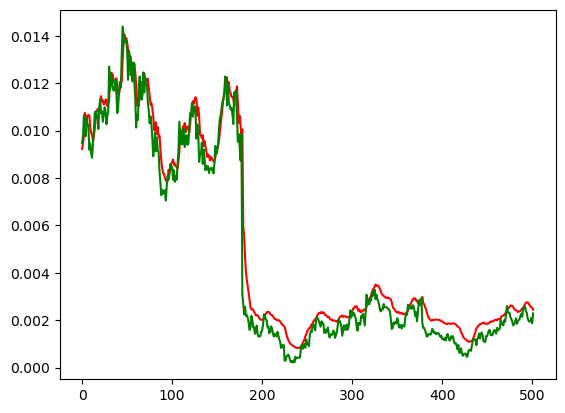

In [14]:
from matplotlib import pyplot as plt
pred_test = CNN_model.predict(X_test)
plt.plot(pred_test,'r')  # 예측 종가값(정규화된 값)
plt.plot(y_test,'g')     # 실제 종가값(정규화된 값)

# 최신데이터 적용

In [16]:
# 데이터 수집
df2 = yfinance.download('AAPL','2023-12-1','2024-1-18')
df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)
display("< original dataset >", df2.tail(10))

# 정규화
dataset2, minmax2 = normalize_data(df2)
values2 = dataset2.values
display("< nomalized dataset >", dataset2.head(21),dataset2.shape)
# 종가 예측은 11번째부터 시작 (12.15일부터)

# 데이터 전처리
n_steps = 10   # 10일분량씩 쪼개어, 인풋데이터를 만듦
new_X,new_y,new_n_features = data_setup(n_steps, values2)
display("new_X", new_X[:3], new_X.shape)
display("new_y", new_y, new_y.shape)

[*********************100%%**********************]  1 of 1 completed
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_94023/3940020885.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)
/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_94023/3940020885.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2 = df2.drop(['Volume'],1).drop(['Adj Close'],1)


'< original dataset >'

,Open,High,Low,Close
Date,,,,
2024-01-03,184.220001,185.880005,183.429993,184.250000
2024-01-04,182.149994,183.089996,180.880005,181.910004
2024-01-05,181.990005,182.759995,180.169998,181.179993
2024-01-08,182.089996,185.600006,181.500000,185.559998
2024-01-09,183.919998,185.149994,182.729996,185.139999
2024-01-10,184.350006,186.399994,183.919998,186.190002
2024-01-11,186.539993,187.050003,183.619995,185.589996
2024-01-12,186.059998,186.740005,185.190002,185.919998
2024-01-16,182.160004,184.259995,180.929993,183.630005


'< nomalized dataset >'

,0,1,2,3
Date,,,,
2023-12-01,0.540895,0.521946,0.538324,0.594212
2023-12-04,0.520000,0.432385,0.432561,0.487300
2023-12-05,0.533731,0.690391,0.594771,0.722977
2023-12-06,0.786865,0.711744,0.709448,0.658004
2023-12-07,0.737911,0.725979,0.797385,0.773184
2023-12-08,0.771940,0.784698,0.802139,0.858240
2023-12-11,0.706865,0.636418,0.668449,0.708801
2023-12-12,0.705074,0.709372,0.686275,0.799174
2023-12-13,0.825074,0.903915,0.872252,0.991140


(31, 4)

< X > 
 [[[0.5408954  0.5219456  0.53832424 0.59421194]
  [0.5199995  0.43238482 0.43256077 0.48730043]
  [0.53373146 0.6903914  0.59477085 0.7229769 ]
  [0.78686523 0.7117438  0.7094475  0.6580041 ]
  [0.7379105  0.725979   0.79738545 0.773184  ]
  [0.7719399  0.7846981  0.8021389  0.85824025]
  [0.70686543 0.63641816 0.6684491  0.7088006 ]
  [0.7050745  0.7093717  0.6862746  0.79917353]
  [0.82507414 0.90391487 0.8722523  0.99114037]
  [1.         1.         0.95008934 1.        ]]

 [[0.5199995  0.43238482 0.43256077 0.48730043]
  [0.53373146 0.6903914  0.59477085 0.7229769 ]
  [0.78686523 0.7117438  0.7094475  0.6580041 ]
  [0.7379105  0.725979   0.79738545 0.773184  ]
  [0.7719399  0.7846981  0.8021389  0.85824025]
  [0.70686543 0.63641816 0.6684491  0.7088006 ]
  [0.7050745  0.7093717  0.6862746  0.79917353]
  [0.82507414 0.90391487 0.8722523  0.99114037]
  [1.         1.         0.95008934 1.        ]
  [0.9707459  0.9276393  1.         0.96810436]]] (21, 10, 4)
< y > 
 [[0.9707

'new_X'

array([[[0.5408954 , 0.5219456 , 0.53832424, 0.59421194],
        [0.5199995 , 0.43238482, 0.43256077, 0.48730043],
        [0.53373146, 0.6903914 , 0.59477085, 0.7229769 ],
        [0.78686523, 0.7117438 , 0.7094475 , 0.6580041 ],
        [0.7379105 , 0.725979  , 0.79738545, 0.773184  ],
        [0.7719399 , 0.7846981 , 0.8021389 , 0.85824025],
        [0.70686543, 0.63641816, 0.6684491 , 0.7088006 ],
        [0.7050745 , 0.7093717 , 0.6862746 , 0.79917353],
        [0.82507414, 0.90391487, 0.8722523 , 0.99114037],
        [1.        , 1.        , 0.95008934, 1.        ]],

       [[0.5199995 , 0.43238482, 0.43256077, 0.48730043],
        [0.53373146, 0.6903914 , 0.59477085, 0.7229769 ],
        [0.78686523, 0.7117438 , 0.7094475 , 0.6580041 ],
        [0.7379105 , 0.725979  , 0.79738545, 0.773184  ],
        [0.7719399 , 0.7846981 , 0.8021389 , 0.85824025],
        [0.70686543, 0.63641816, 0.6684491 , 0.7088006 ],
        [0.7050745 , 0.7093717 , 0.6862746 , 0.79917353],
        [0.8

(21, 10, 4)

'new_y'

array([0.96810436, 0.8688718 , 0.93089205, 0.80626124, 0.7974007 ,
       0.73360944, 0.7011226 , 0.7070287 , 0.73242784, 0.6704076 ,
       0.26343796, 0.18133526, 0.04311935, 0.        , 0.2587125 ,
       0.2339046 , 0.29592484, 0.26048443, 0.27997658, 0.14471418,
       0.08860008], dtype=float32)

(21,)

1/1 [==============================] - 0s 7ms/step


array([[0.91425204],
       [0.9169276 ],
       [0.83885443],
       [0.90345454],
       [0.89478064]], dtype=float32)

21

[ 손실함수 ]
CNN MSE: 0.018446127


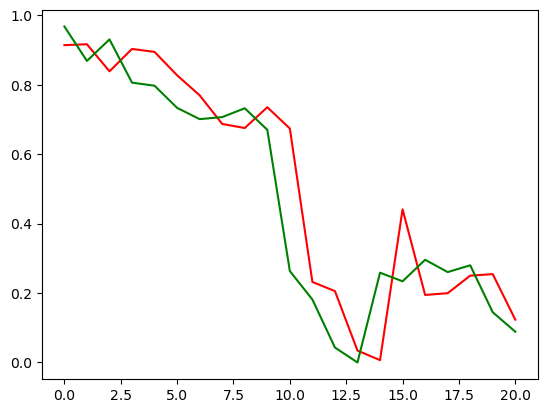

In [21]:
from sklearn.metrics import mean_squared_error

# 예측하기
pred_Apple = CNN_model.predict(new_X)
display(pred_Apple[:5], len(pred_Apple))

print("[ 손실함수 ]")
CNN_mse = mean_squared_error(new_y, pred_Apple)
print("CNN MSE:", CNN_mse)

# 정규화 예측값 시각화
plt.plot(pred_Apple,'r')  # 예측 종가값(정규화된 값)
plt.plot(new_y,'g')     # 실제 종가값(정규화된 값)

In [19]:
import numpy as np

# 실제값과 예측값 비교 (여기서 new_y는 실제값을 나타냄)
pred_Apple = CNN_model.predict(new_X)

# 퍼센트 오차 계산
percent_errors = np.abs((pred_Apple.flatten() - new_y) / new_y)

# 허용 오차 설정 (예: 10% 이내를 정확한 예측으로 간주)
tolerance = 0.1

# 정확한 예측의 비율 계산
accuracy = np.mean(percent_errors < tolerance)
print(f"예측 정확도: {accuracy * 100:.2f}%")

1/1 [==============================] - 0s 15ms/step
예측 정확도: 33.33%


/var/folders/69/0x25zsbs24x5sj1x4z6z0sth0000gn/T/ipykernel_94023/4104885786.py:7: RuntimeWarning: divide by zero encountered in true_divide
  percent_errors = np.abs((pred_Apple.flatten() - new_y) / new_y)
